In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/mnist.npz
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [6]:
mnist.load_data?

Object `mnist.load_data` not found.


In [7]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import numpy as np # Set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
from keras.datasets import mnist
import numpy as np

# Load the MNIST dataset from the local Kaggle directory
fname = '/kaggle/input/mnist-dataset/mnist.npz'

# Load the dataset using np.load since it's already downloaded
with np.load(fname, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

# Optionally, you can normalize the dataset manually as Keras datasets are NumPy arrays
x_train = x_train.astype('float32') / 255.0  # Normalize between 0 and 1
x_test = x_test.astype('float32') / 255.0

# The labels are already loaded, so no need to convert them here
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader,ConcatDataset
import numpy as np
import torchvision.transforms as transforms

# Load the MNIST dataset from the local Kaggle directory
fname = '/kaggle/input/mnist-dataset/mnist.npz'

with np.load(fname, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

# Normalize the pixel values and apply the necessary transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert NumPy array to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Create a custom dataset class to handle the data
class MNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        # Convert image to 1 channel and apply transforms if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create training and test datasets using the custom dataset class
train_dataset = MNISTDataset(x_train, y_train, transform=transform)
test_dataset = MNISTDataset(x_test, y_test, transform=transform)

# Combine the training and test datasets into a single dataset
combined_dataset = ConcatDataset([train_dataset, test_dataset])

# Use DataLoader to load the combined data in batches and shuffle
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Example: Iterate through onatch of the combined data
for images, labels in dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break  # Just show the first batch


Batch of images shape: torch.Size([32, 1, 28, 28])
Batch of labels shape: torch.Size([32])


In [10]:
# Hyperparameters 
latent_dim = 100 
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 
num_epochs = 10

In [11]:
# Define the generator
import torch.nn as nn

class Generator(nn.Module): 
    def __init__(self, latent_dim): 
        super(Generator, self).__init__()
        self.model = nn.Sequential( nn.Linear(latent_dim, 128 * 7 * 7), 
                                   nn.ReLU(),
                                   nn.Unflatten(1, (128, 7, 7)),
                                   
                                   nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
                                   nn.BatchNorm2d(128, momentum=0.78),
                                   nn.ReLU(), 
                                
                                   nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                                  
                                   nn.BatchNorm2d(64, momentum=0.78),
                                   nn.ReLU(), 
                                   nn.Conv2d(64, 1, kernel_size=3, padding=1), 
                                   nn.Tanh() 
                                  ) 
    def forward(self, z):
        img = self.model(z) 
        return img

In [12]:
# Define the discriminator 
class Discriminator(nn.Module):  
    def forward(self, img): 
        validity = self.model(img)
        return validity
    
    def __init__(self): 
        super(Discriminator, self).__init__()
        self.model = nn.Sequential( nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
                                       nn.LeakyReLU(0.2),
                                       nn.Dropout(0.25),
                                       nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                                       nn.ZeroPad2d((0, 1, 0, 1)),
                                       nn.BatchNorm2d(64, momentum=0.82),
                                       nn.LeakyReLU(0.25), 
                                       nn.Dropout(0.25), 
                                       nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
                                       nn.BatchNorm2d(128, momentum=0.82), 
                                       nn.LeakyReLU(0.2), 
                                       nn.Dropout(0.25), 
                                       nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
                                       nn.BatchNorm2d(256, momentum=0.8), 
                                       nn.LeakyReLU(0.25),
                                       nn.Dropout(0.25), 
                                       nn.Flatten(), 
                                       nn.Linear(64 * 8 * 8, 1), nn.Sigmoid())
 


In [13]:
# Define the generator and discriminator # Initialize generator and discriminator 
generator = Generator(latent_dim).to(device) 
discriminator = Discriminator().to(device) 
# Loss function 
adversarial_loss = nn.BCELoss() 
# Optimizers 
optimizer_G = optim.Adam(generator.parameters() ,
                         lr=lr,
                         betas=(beta1, beta2)) 
optimizer_D = optim.Adam(discriminator.parameters() , 
                         lr=lr,
                         betas=(beta1, beta2))

Epoch [1/10]\ Batch 100/2188 Discriminator Loss: 1.4026 Generator Loss: 0.1641
Epoch [1/10]\ Batch 200/2188 Discriminator Loss: 1.5830 Generator Loss: 0.0955
Epoch [1/10]\ Batch 300/2188 Discriminator Loss: 1.8212 Generator Loss: 0.0707
Epoch [1/10]\ Batch 400/2188 Discriminator Loss: 1.8584 Generator Loss: 0.0577
Epoch [1/10]\ Batch 500/2188 Discriminator Loss: 1.9981 Generator Loss: 0.0501
Epoch [1/10]\ Batch 600/2188 Discriminator Loss: 1.9869 Generator Loss: 0.0409
Epoch [1/10]\ Batch 700/2188 Discriminator Loss: 2.0867 Generator Loss: 0.0372
Epoch [1/10]\ Batch 800/2188 Discriminator Loss: 2.2206 Generator Loss: 0.0337
Epoch [1/10]\ Batch 900/2188 Discriminator Loss: 2.2451 Generator Loss: 0.0299
Epoch [1/10]\ Batch 1000/2188 Discriminator Loss: 2.2135 Generator Loss: 0.0318
Epoch [1/10]\ Batch 1100/2188 Discriminator Loss: 2.2707 Generator Loss: 0.0283
Epoch [1/10]\ Batch 1200/2188 Discriminator Loss: 2.2903 Generator Loss: 0.0255
Epoch [1/10]\ Batch 1300/2188 Discriminator Loss:

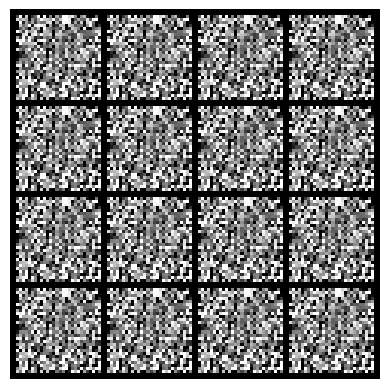

Epoch [10/10]\ Batch 200/2188 Discriminator Loss: 2.7941 Generator Loss: 0.0086


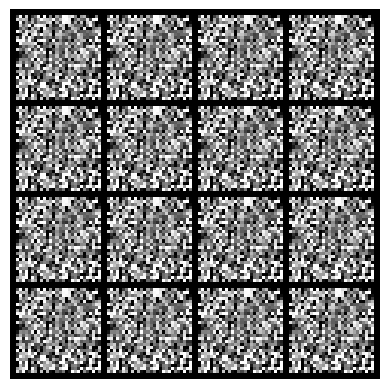

Epoch [10/10]\ Batch 300/2188 Discriminator Loss: 2.8322 Generator Loss: 0.0089


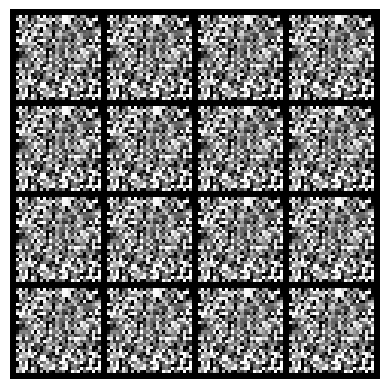

Epoch [10/10]\ Batch 400/2188 Discriminator Loss: 2.7842 Generator Loss: 0.0087


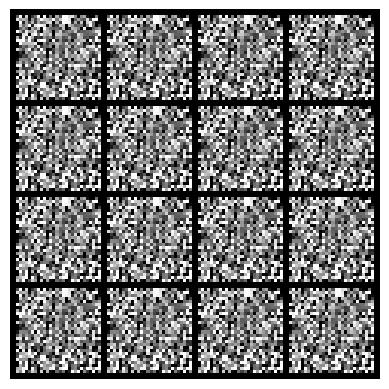

Epoch [10/10]\ Batch 500/2188 Discriminator Loss: 2.8077 Generator Loss: 0.0106


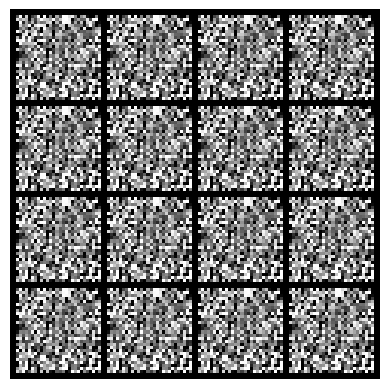

Epoch [10/10]\ Batch 600/2188 Discriminator Loss: 2.7953 Generator Loss: 0.0086


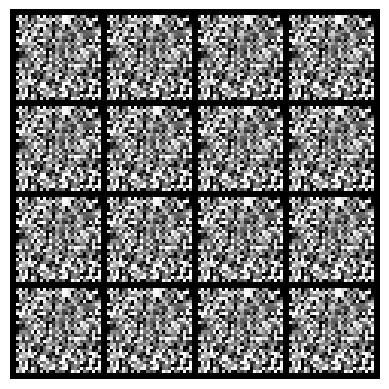

Epoch [10/10]\ Batch 700/2188 Discriminator Loss: 2.8080 Generator Loss: 0.0089


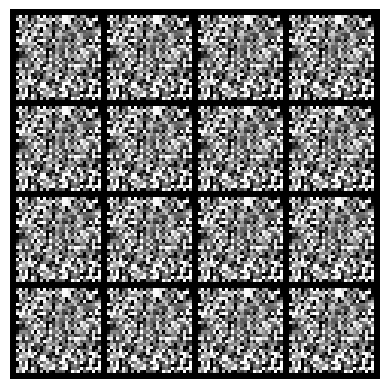

Epoch [10/10]\ Batch 800/2188 Discriminator Loss: 2.8048 Generator Loss: 0.0108


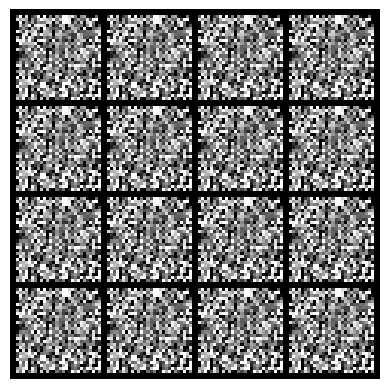

Epoch [10/10]\ Batch 900/2188 Discriminator Loss: 2.7326 Generator Loss: 0.0088


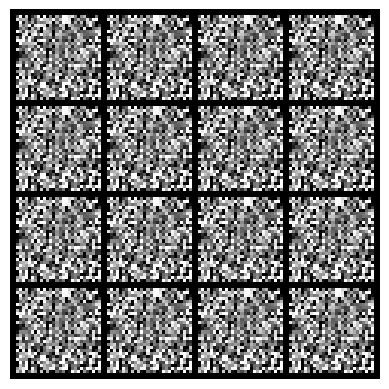

Epoch [10/10]\ Batch 1000/2188 Discriminator Loss: 2.7600 Generator Loss: 0.0083


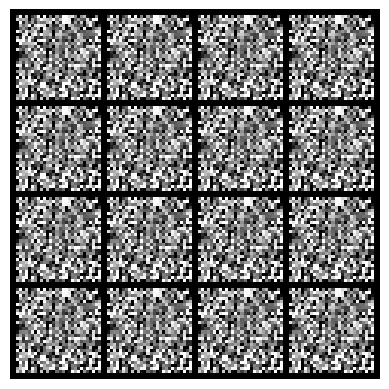

Epoch [10/10]\ Batch 1100/2188 Discriminator Loss: 2.7827 Generator Loss: 0.0107


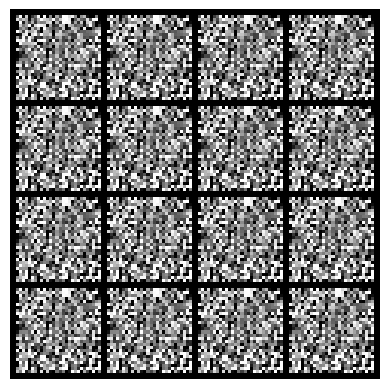

Epoch [10/10]\ Batch 1200/2188 Discriminator Loss: 2.8268 Generator Loss: 0.0096


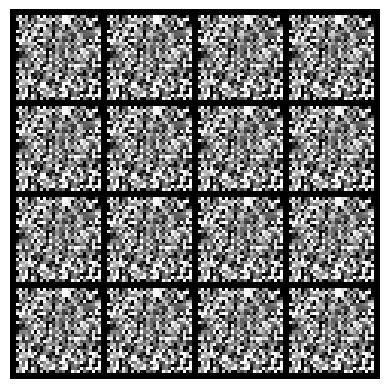

Epoch [10/10]\ Batch 1300/2188 Discriminator Loss: 2.7461 Generator Loss: 0.0094


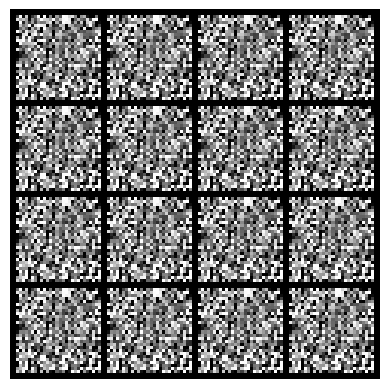

Epoch [10/10]\ Batch 1400/2188 Discriminator Loss: 2.8530 Generator Loss: 0.0087


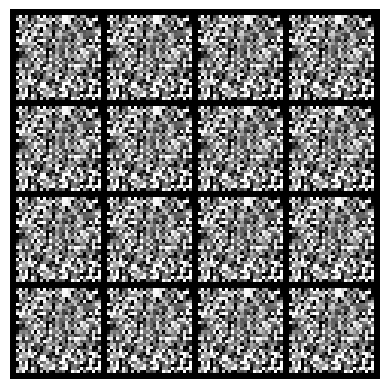

Epoch [10/10]\ Batch 1500/2188 Discriminator Loss: 2.7859 Generator Loss: 0.0091


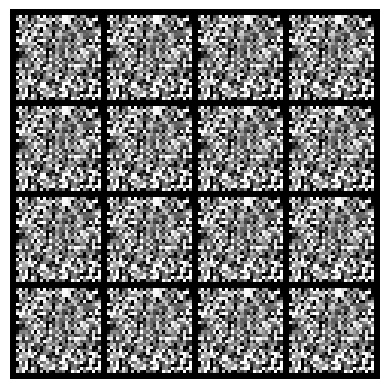

Epoch [10/10]\ Batch 1600/2188 Discriminator Loss: 2.8228 Generator Loss: 0.0089


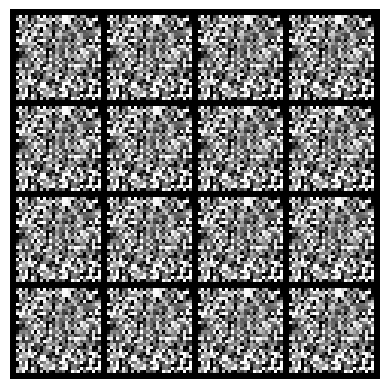

Epoch [10/10]\ Batch 1700/2188 Discriminator Loss: 2.8133 Generator Loss: 0.0089


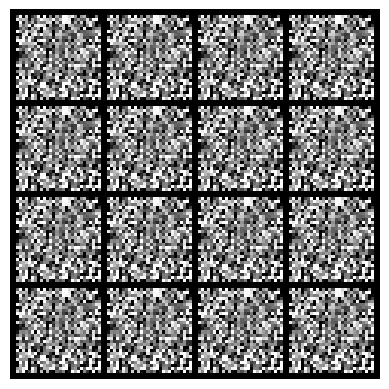

Epoch [10/10]\ Batch 1800/2188 Discriminator Loss: 2.7663 Generator Loss: 0.0093


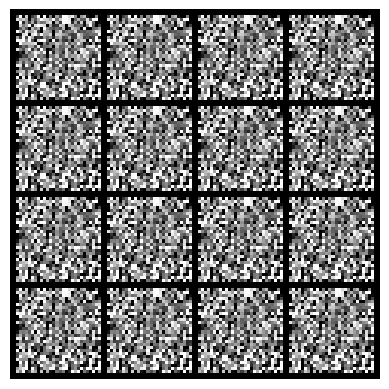

Epoch [10/10]\ Batch 1900/2188 Discriminator Loss: 2.7800 Generator Loss: 0.0099


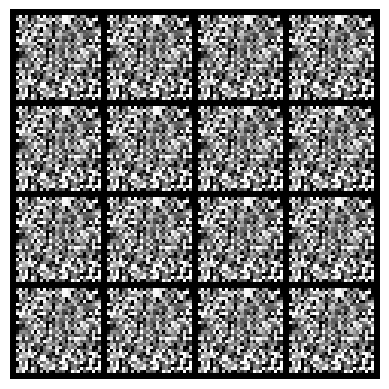

Epoch [10/10]\ Batch 2000/2188 Discriminator Loss: 2.8062 Generator Loss: 0.0092


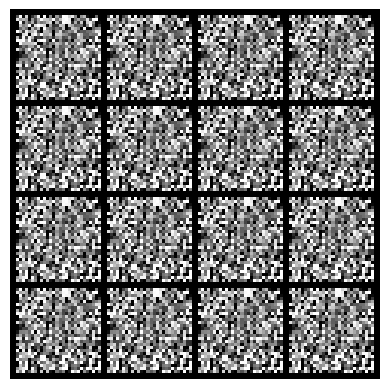

Epoch [10/10]\ Batch 2100/2188 Discriminator Loss: 2.8154 Generator Loss: 0.0092


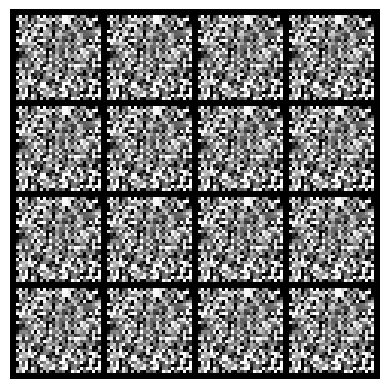

In [14]:
# Training loop
for epoch in range(num_epochs): 
    for i, batch in enumerate(dataloader): 
        # Convert list to tensor 
        real_images = batch[0].to(device)
        # Adversarial ground truths 
        valid = torch.ones(real_images.size(0), 1, device=device) 
        fake = torch.zeros(real_images.size(0), 1, device=device) 
        # Configure input 
        real_images = real_images.to(device)
        # --------------------- 
        # Train Discriminator
        #---------------------
        optimizer_D.zero_grad() 
        # Sample noise as generator input 
        z = torch.randn(real_images.size(0), latent_dim, device=device) 
        # Generate a batch of images 
        fake_images = generator(z) 
        # Measure discriminator's ability 
        # to classify real and fake images 
        real_loss = adversarial_loss(discriminator (real_images), valid) 
        fake_loss = adversarial_loss(discriminator (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2 
        # Backward pass and optimize d_loss.backward() 
        optimizer_D.step() 
        # ----------------- 
        # Train Generator
        # ----------------- 
        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z) # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid) # Backward pass and optimize 
        g_loss.backward() 
        optimizer_G.step() 
        # --------------------- 
        # Progress Monitoring
        #  --------------------- 
        if (i + 1) % 100 == 0:
            print( f"Epoch [{epoch+1}/{num_epochs}]\ Batch {i+1}/{len(dataloader)} " f"Discriminator Loss: {d_loss.item():.4f} " f"Generator Loss: {g_loss.item():.4f}" ) 
            # Save generated images for every epoch
            if (epoch + 1) % 10 == 0: 
                with torch.no_grad(): 
                    z = torch.randn(16, latent_dim, device=device) 
                    generated = generator(z).detach().cpu() 
                    grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
                    plt.imshow(np.transpose(grid, (1, 2, 0))) 
                    plt.axis("off")
                    plt.show()

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset from a local .npz file
def load_data():
    fname = '/kaggle/input/mnist-dataset/mnist.npz'  # Adjust the path as necessary
    with np.load(fname, allow_pickle=True) as f:
        x_train, y_train = f['x_train'], f['y_train']
    
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension (for grayscale)
    return x_train

# Generator model
def build_generator():
    model = models.Sequential()
    
    model.add(layers.Dense(256, input_dim=100))
   


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset from a local .npz file
def load_data():
    fname = '/kaggle/input/mnist-dataset/mnist.npz'  # Adjust the path as necessary
    with np.load(fname, allow_pickle=True) as f:
        x_train, y_train = f['x_train'], f['y_train']
    
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension (for grayscale)
    return x_train

# Generator model
def build_generator():
    model = models.Sequential()
    
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    
    return model

# Discriminator model
def build_discriminator():
    model = models.Sequential()
    
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# GAN combining generator and discriminator
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Only train the generator in GAN combined model
    model = models.Sequential([generator, discriminator])
    return model

# Training function for GAN
def train(gan, generator, discriminator, epochs, batch_size=128, sample_interval=1000):
    # Load the data
    X_train = load_data()
    
    # Labels for real and fake data
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator (through the GAN model, where the discriminator is frozen)
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)
        
        # Print progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc: {100 * d_loss[1]}] [G loss: {g_loss}]")
            sample_images(generator, epoch)

# Function to generate and save images from the generator
def sample_images(generator, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1]
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"/epoch_{epoch}.png")
    plt.close()

# Main function to run GAN
if __name__ == '__main__':
    # Build the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
    
    # Build the generator
    generator = build_generator()
    
    # Build and compile the GAN
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    
    # Train the GAN
    train(gan, generator, discriminator, epochs=10000, batch_size=64, sample_interval=1000)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
0 [D loss: 0.8790766000747681, acc: 19.921875] [G loss: [array(0.8233278, dtype=float32), array(0.8233278, dtype=float32), array(0.2578125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━

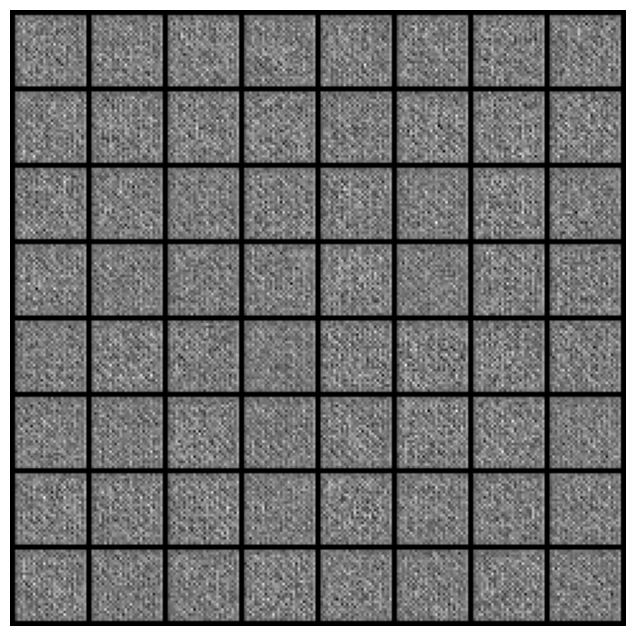

Discriminator accuracy on generated images: 0.00%


In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def evaluate_gan(generator, discriminator, latent_dim, num_samples=64, device='cuda'):
    """
    Function to evaluate the trained GAN model by generating images and checking the discriminator's performance.
    
    Args:
    - generator: Trained generator model.
    - discriminator: Trained discriminator model.
    - latent_dim: Dimension of the noise vector.
    - num_samples: Number of images to generate for evaluation.
    - device: 'cuda' for GPU or 'cpu' for CPU.
    """
    # Set the models to evaluation mode
    generator.eval()
    discriminator.eval()
    
    with torch.no_grad():
        # Generate random noise as input for the generator
        z = torch.randn(num_samples, latent_dim, device=device)
        
        # Generate images from the noise
        generated_images = generator(z).detach().cpu()
        
        # Plot the generated images for visual inspection
        grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis("off")
        plt.show()
        
        # Generate labels for evaluation (1 for real, 0 for fake)
        real_labels = torch.ones(num_samples, 1, device=device)
        fake_labels = torch.zeros(num_samples, 1, device=device)
        
        # Measure the discriminator's accuracy on generated images
        discriminator_output_fake = discriminator(generated_images.to(device))
        fake_accuracy = (discriminator_output_fake < 0.5).float().mean().item()
        
        print(f"Discriminator accuracy on generated images: {fake_accuracy * 100:.2f}%")
    
    # Switch models back to training mode
    generator.train()
    discriminator.train()
# After the training loop
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
evaluate_gan(generator, discriminator, latent_dim=latent_dim, num_samples=64, device=device)
